In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Introduction

**Historical Background**
- The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

- While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
<br><br>

**Goals**
- In this notebook, I aim to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).
<br><br>

**Attribute Information**
- Identifier
  - `Passenger ID` - ID of the Passenger
- Target Variable
  - `survival` - Survival	0 = No, 1 = Yes

- Features
  - `pclass` - Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
  - `sex` - Sex
  - `Age` - Age in years
  - `sibsp` - # of siblings / spouses aboard the Titanic
  - `parch` - # of parents / children aboard the Titanic
  - `ticket` - Ticket number
  - `fare` -  Passenger fare
  - `cabin` - Cabin number
  - `embarked` - Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# 2. Importing Libraries

In [2]:
# libraries
# basic
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':1.5})
# change the maximum width in characters of a column (default: 50)
pd.set_option('display.max_colwidth', None)
# change the display precision for better viz
pd.set_option('display.precision', 3)

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

# train test split
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

# model evaluation & tuning hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# explainable AI
import shap

# 3. Data Understanding

## 3.1 Load the data

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([train_data, test_data], ignore_index = True, sort = False)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [4]:
#exclude identifier from features
data.drop('PassengerId', axis=1, inplace=True)

In [5]:
data.shape

(1309, 11)

## 3.2 Define Categorical dan Numerical Variable

In [6]:
#define numerical and categorical features
column_numerical = ['Age','SibSp','Parch','Fare']
column_categorical = list(data.columns)
column_categorical.remove('Age')
column_categorical.remove('SibSp')
column_categorical.remove('Parch')
column_categorical.remove('Fare')
data_type_general = dict()

for col in data.columns:
  if col in column_numerical:
    data_type_general[col] = 'numerical'
  else:
    data_type_general[col] = 'categorical'

tmp = pd.Series(data_type_general)
data_type_general = pd.DataFrame(tmp).T.rename({0:'general data types'})
data_type_general

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
general data types,categorical,categorical,categorical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,categorical


In [7]:
data_type_python = pd.DataFrame(data.dtypes).T.rename({0:'python data types'})
data_type_python

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
python data types,float64,int64,object,object,float64,int64,int64,object,float64,object,object


## 3.3 Null value Checking

In [8]:
data_null_total = pd.DataFrame(data.isna().sum()).T.rename({0:'total null'})
data_null_total

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
total null,418,0,0,0,263,0,0,0,1,1014,2


> ada banyak data null di Age dan Cabin, in perlu penindakan lebih lanjut saat di Exploratory Data Analysis.

# 4. Exploratory Data Analysis

In [9]:
# only contains input features
column_categorical.remove('Survived')
column_categorical

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [10]:
#data for visualization
data_viz = data.copy()
# data_viz.loc[:,'Survived'] = data_viz.loc[:, 'Survived'].apply(lambda x: 'Survived' if x == 1.0 else 'Not Survived')
data_viz['Survived'] = data_viz['Survived'].map({1.0: 'Survived', 0.0: 'Not Survived'})

In [11]:
def stacked_bar_plot(data, x, y, orient='horizontal', ax=None, show=True):
    # create axis if not present
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    # create crosstab based on the input data
    crosstab = pd.crosstab(index=data[x], columns=data[y], normalize='index')
    crosstab = crosstab.reindex(['Survived', 'Not Survived'], axis=1)  # Reorder the columns
    
    # visualize stacked barplot
    if orient == 'vertical':
        # order in descending (the highest value on the left)
        crosstab = crosstab.sort_values('Survived', ascending=False)
        crosstab.plot(kind='bar', stacked=True, ax=ax, color=['#27aeef','#ea5545'])

        # add percentage label
        for i, index in enumerate(crosstab.index):
            for (proportion, y_loc) in zip(crosstab.loc[index], crosstab.loc[index].cumsum()):
                ax.text(x=i,
                        y=(y_loc - proportion) + (proportion / 2),
                        s=f'{proportion*100:.1f}%',
                        color='white',
                        fontsize=14,
                        fontweight='bold',
                        horizontalalignment='center',
                        verticalalignment='center')
        # remove tick labels
        ax.set_yticklabels([])
    else:  # default is horizontal bar plot, even if the orient input is an arbitrary value
        # orient in ascending (the highest value on the top)
        crosstab = crosstab.sort_values('Survived', ascending=True)
        crosstab.plot(kind='barh', stacked=True, ax=ax, color=['#27aeef','#ea5545'])

        # add percentage label
        for i, index in enumerate(crosstab.index):
            for (proportion, x_loc) in zip(crosstab.loc[index], crosstab.loc[index].cumsum()):
                ax.text(y=i,
                        x=(x_loc - proportion) + (proportion / 2),
                        s=f'{proportion*100:.1f}%',
                        color='white',
                        fontsize=14,
                        fontweight='bold',
                        horizontalalignment='center',
                        verticalalignment='center')
        # remove tick labels
        ax.set_xticklabels([])

    x_title = x.capitalize()
    ax.set_title(f'Passenger Survived Probability by {x_title}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)
    sns.despine(left=True, bottom=True)

    if show:
        plt.show()



## 4.1 Survived Percentage

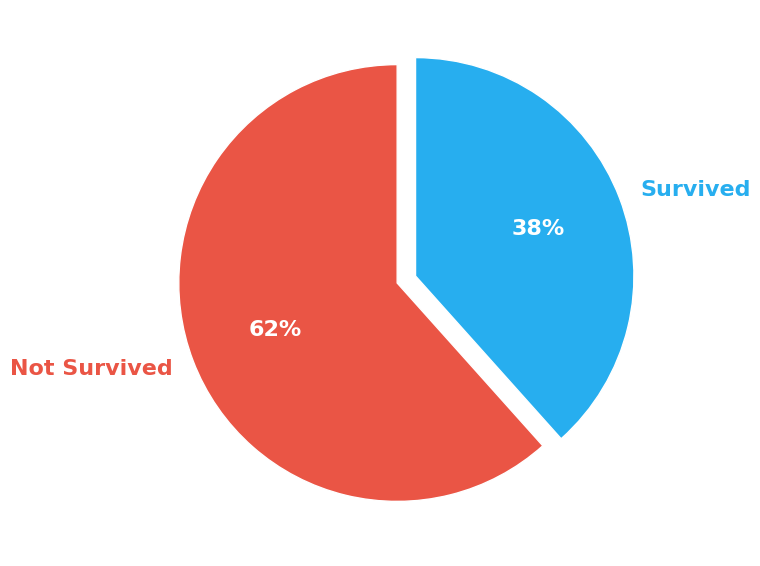

In [12]:
pie_data = data_viz['Survived'].value_counts(normalize=True).values * 100
pie_label = data_viz['Survived'].value_counts(normalize=True).index.to_list()

fig, ax = plt.subplots(figsize=(8,6))

# Define pastel colors for the pie chart (soft blue for Not Survived, soft red for Survived)
colors = ['#ea5545','#27aeef'] 

wedges, texts, autotexts = ax.pie(pie_data, labels=pie_label,
                                  startangle=90, explode=[0, 0.09],
                                  autopct='%.0f%%', colors=colors,  # Set colors parameter
                                  textprops={'color':'w', 'fontsize':16, 'weight':'bold'})
for i, wedge in enumerate(wedges):
  texts[i].set_color(wedge.get_facecolor())

plt.tight_layout()
plt.show()

> the ratio betwwe Survived and Not Survived is almost 4:6. Meaning there is no need to do Oversampling in this particular case.

## 4.2 Features' Overview

### 4.2.1 Passenger Survived by Ticket Class

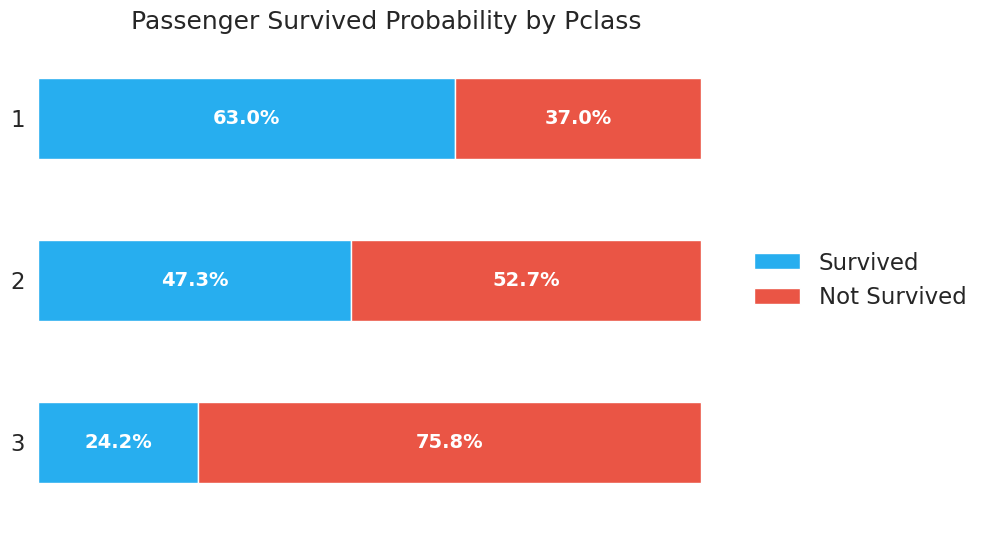

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

stacked_bar_plot(data=data_viz, x='Pclass', y='Survived', ax=ax)


> In this tragedy of Titanic, the highest percentage of Survived Passenger by Ticket Class is those who's in the 1st Class. It continues to shrink down until the 3rd Ticket Class

### 4.2.2 Passenger Survived by Gender

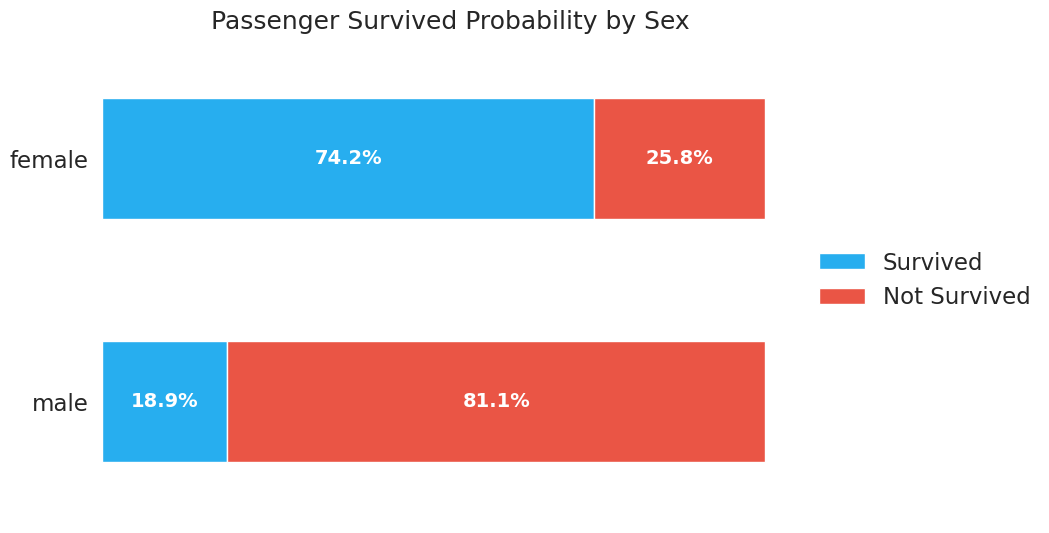

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

stacked_bar_plot(data=data_viz, x='Sex', y='Survived', ax=ax)


> It is clear that in this tragedy, Female Passenger having higher probability to survive than Male Passenger.

### 4.2.3 Cabin Overview and Missing Value Case

stated previously that the Cabin Data is missing, in this part of the Notebook I do the handling.

In [15]:
data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [16]:
data['Cabin'].isnull().sum()

1014

Cabin's missing values are 1014. This large amount of data could not be ignored easily. Let's make a derived variable from it.

In [17]:
data['Has_Cabin'] = data['Cabin'].isnull().astype(int)

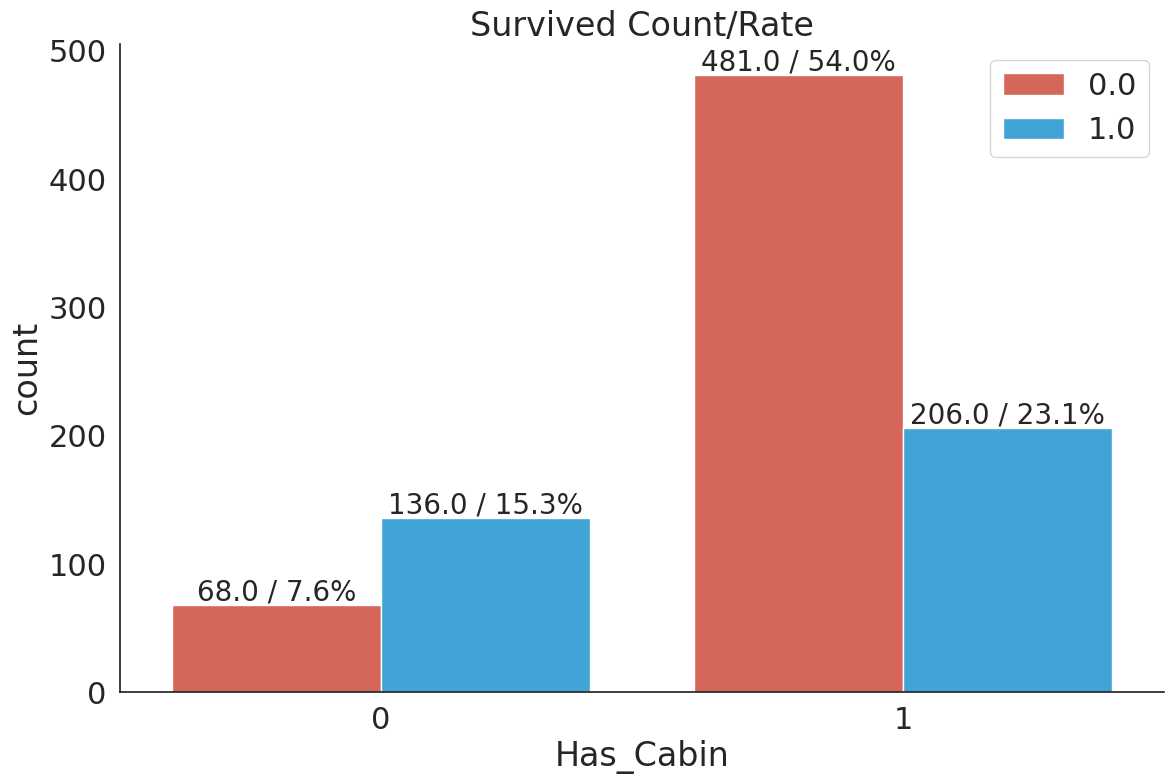

In [18]:
from matplotlib import rcParams

total_cnt = data['Survived'].count()
rcParams['figure.figsize'] = 12, 8
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.countplot(x="Has_Cabin",
                   hue="Survived", 
                   data=data,
                   palette=['#ea5545', '#27aeef'])  # Set custom colors
ax.set_title('Survived Count/Rate')
plt.legend(loc='upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
sns.despine()


> Cases with cabins have more survivors compared to cases without cabins. It is likely that the new derived variable will be helpful in the classification of survivors.

Mean of empty slice


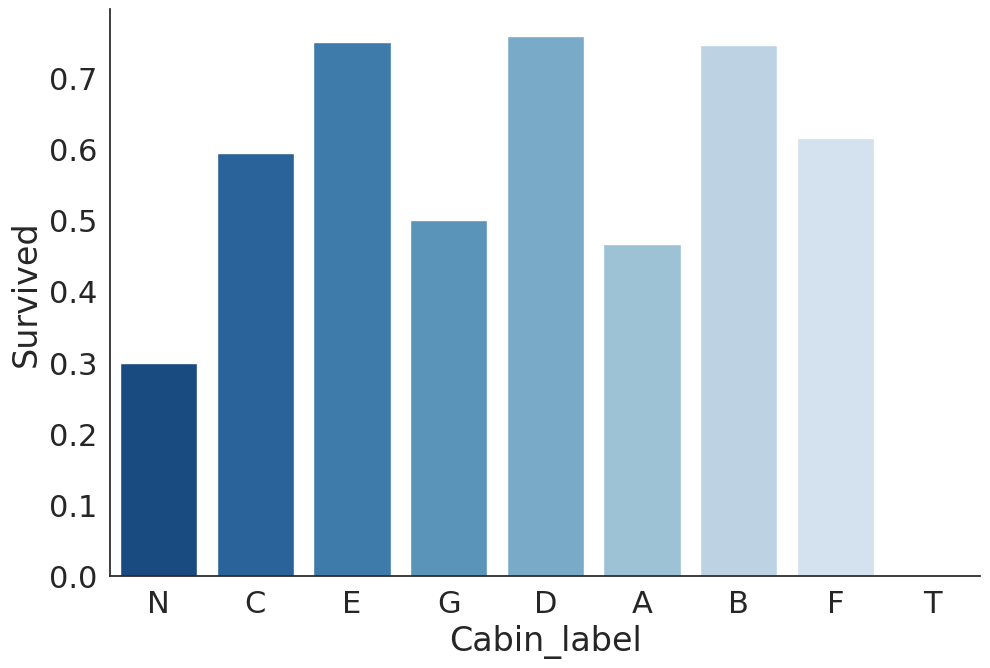

In [19]:
# mengubah Missing value jadi Cabin N
rcParams['figure.figsize'] = 10,7
sns.set(font_scale = 2)
sns.set_style("white")
data['Cabin'] = data['Cabin'].fillna('N')
data['Cabin_label'] = data['Cabin'].str.get(0)
ax = sns.barplot(x = 'Cabin_label', y = 'Survived', data = data, palette = 'Blues_r',errorbar=('ci', False))
sns.despine()

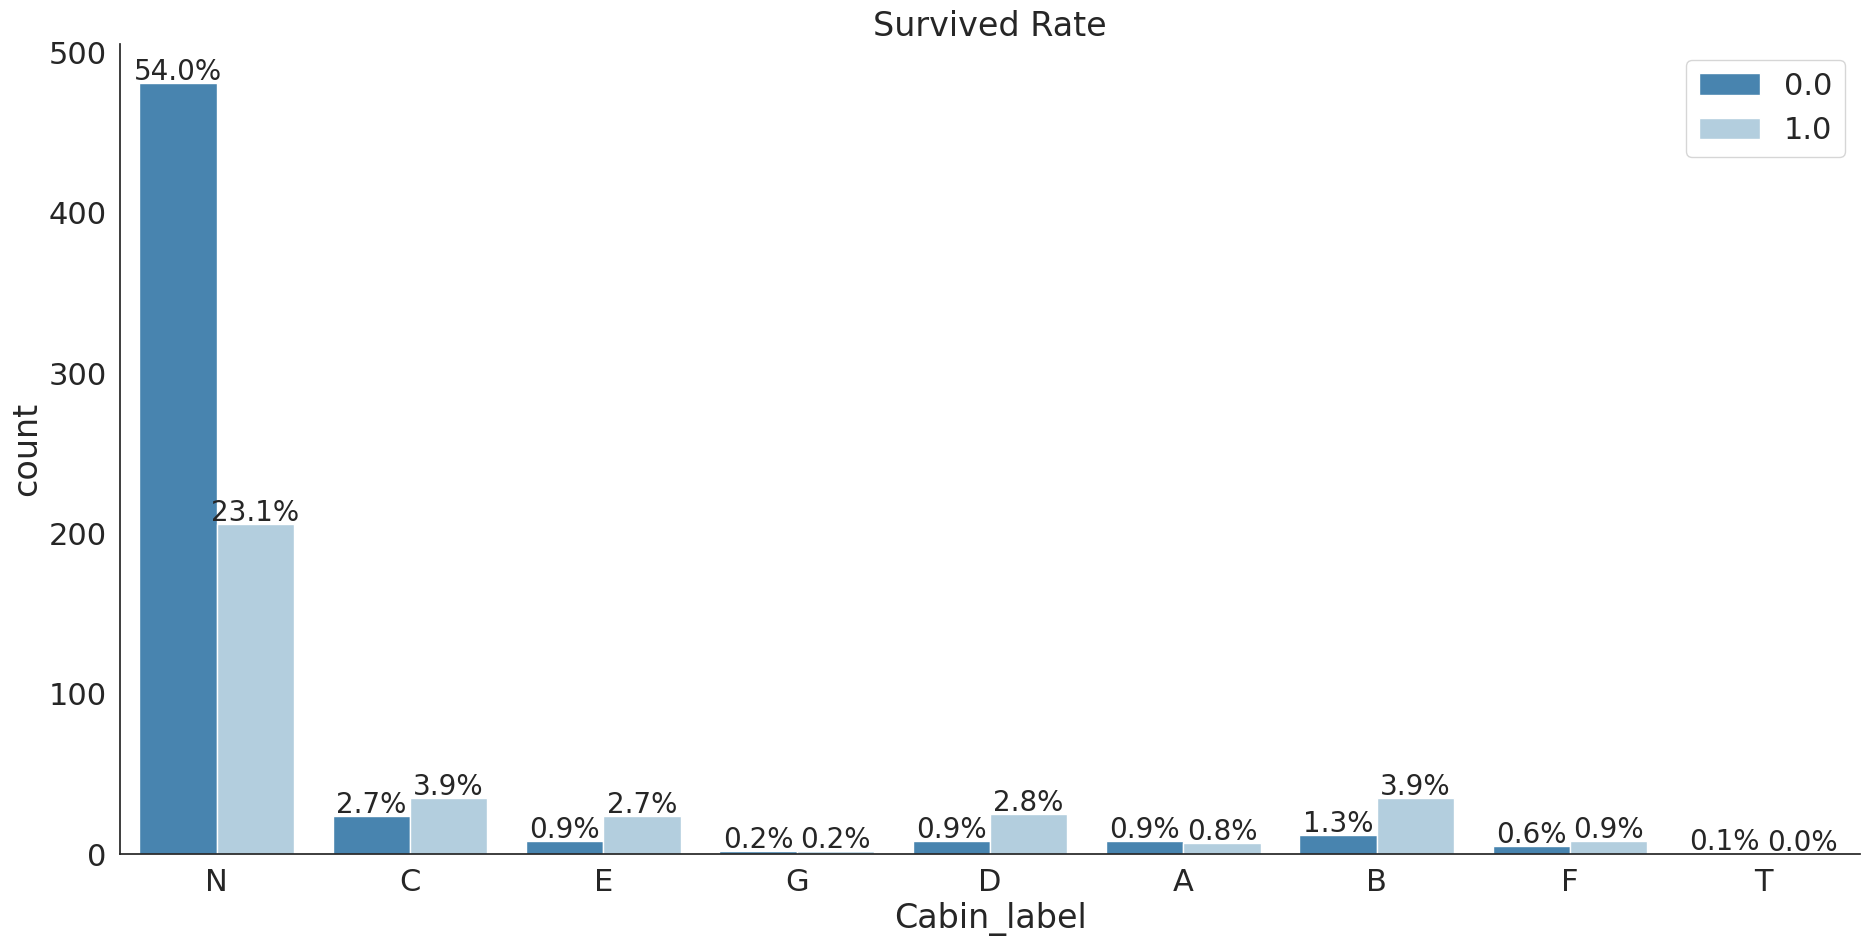

In [20]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x="Cabin_label", hue="Survived", data=data,palette = 'Blues_r')
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

> The missing Data (N) having significant impact to the variety of the data. Thus, we could not delete it easily.

### 4.2.4 Parch and Sibsp Features

Parch meaning # of parents / children aboard the Titanic. Sibsp meaning # of siblings / spouses aboard the Titanic.

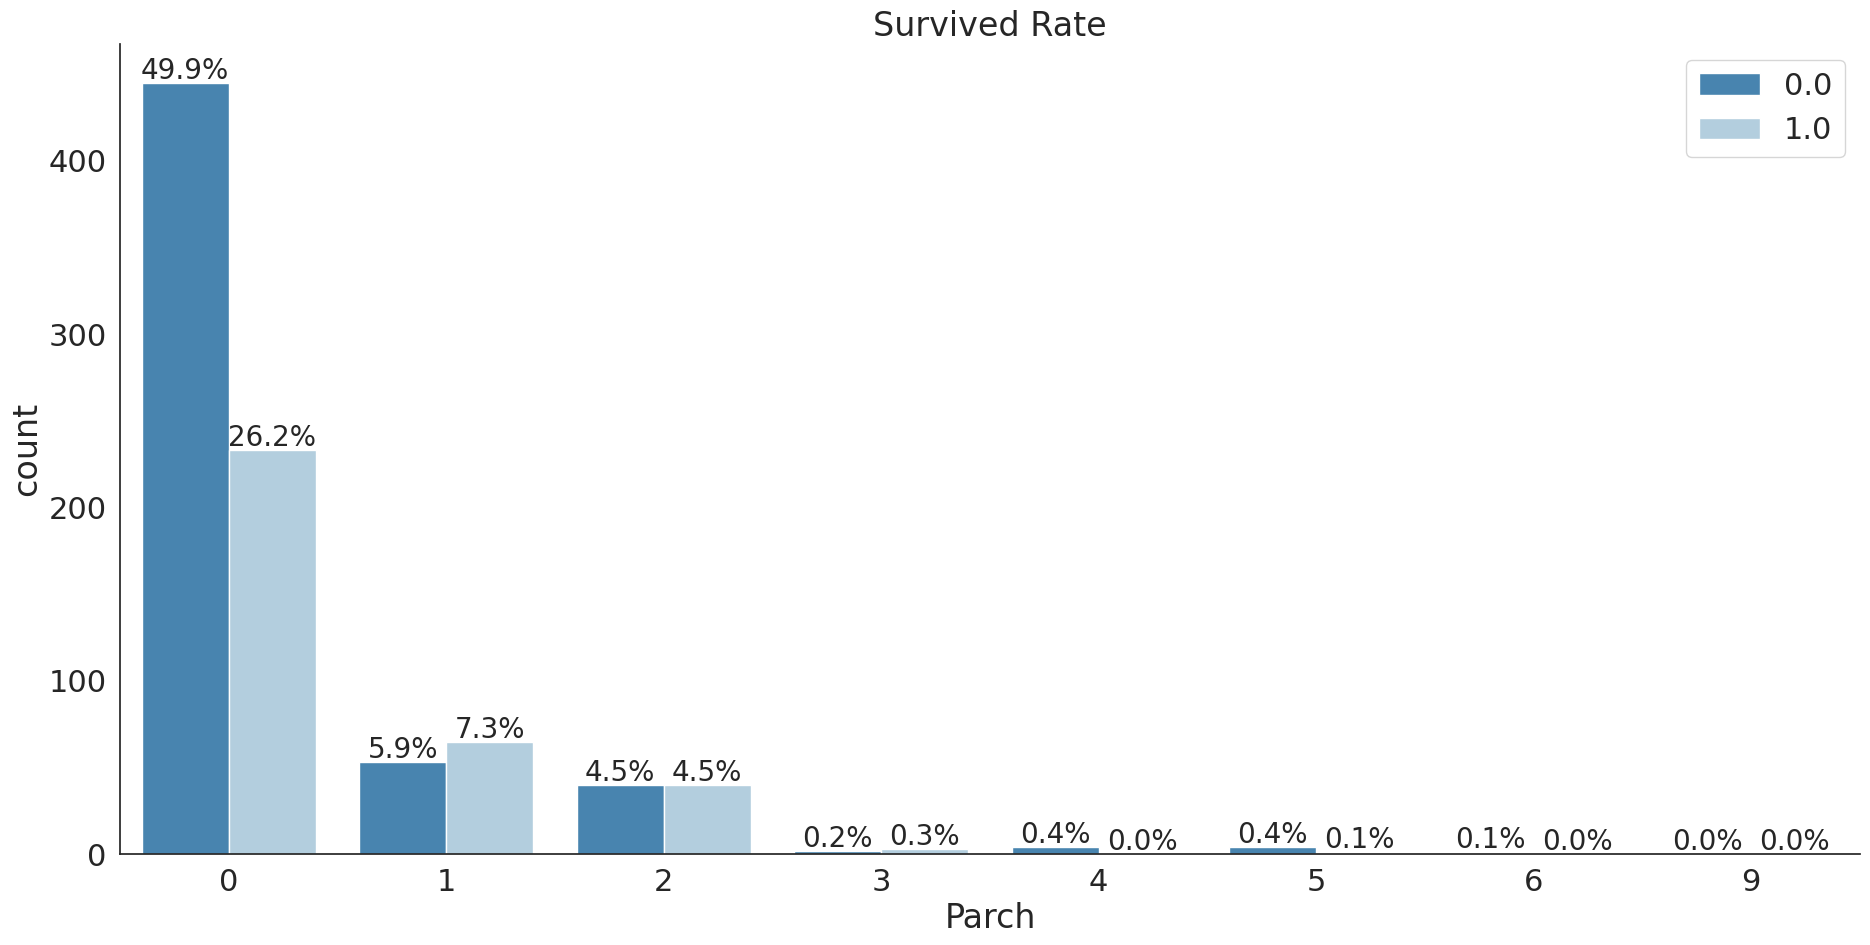

In [21]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='Parch',hue ='Survived',data=data,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

Passenger with no parents / children aboard the Titanic having highest count of death.

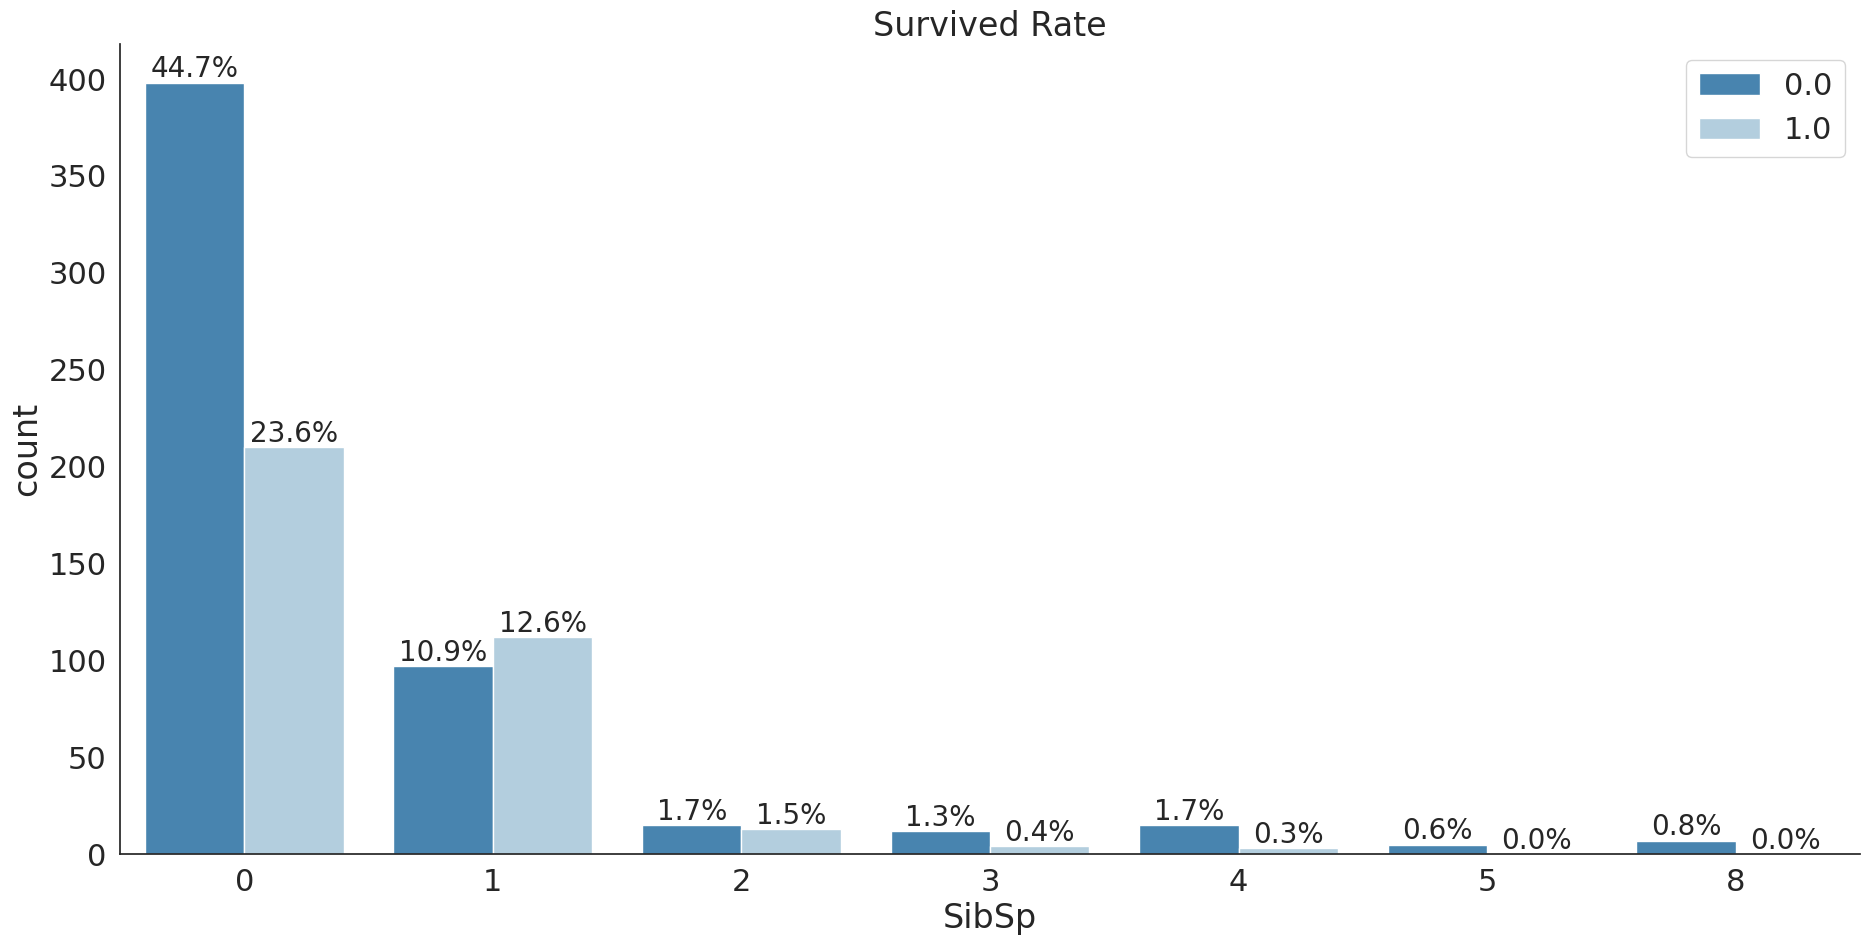

In [22]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='SibSp',hue ='Survived',data=data,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

the same goes for passenger with no siblings/spouse aboard the titanic

In [23]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

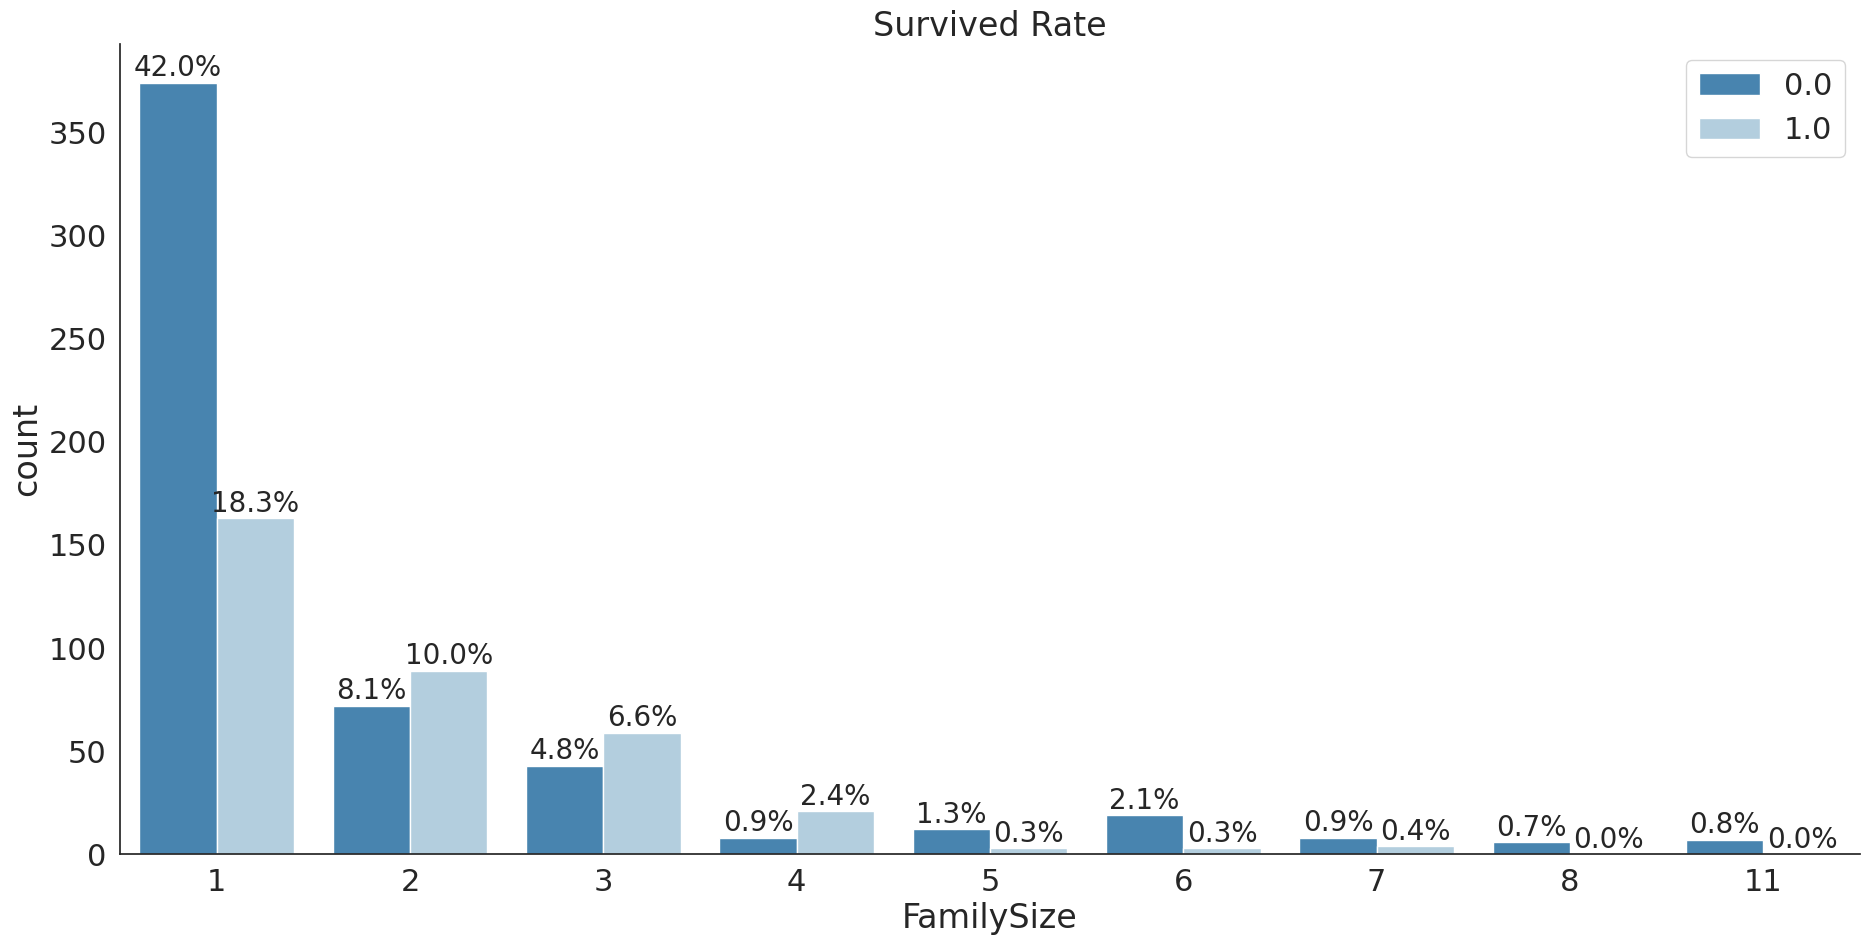

In [24]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='FamilySize',hue ='Survived',data=data,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

In [25]:
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

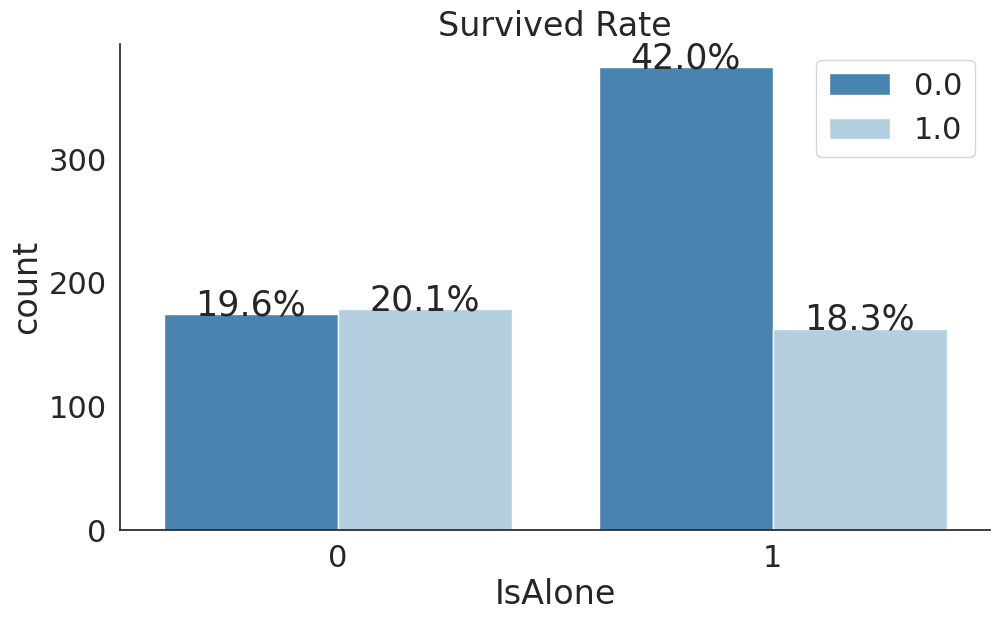

In [26]:
rcParams['figure.figsize'] = 10,6
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='IsAlone',hue ='Survived',data=data,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=25)
sns.despine()

> If we generates new Variable from Parch and Sibs, we could understand that passenger who is alone aboard the Titanic having the highest probability of Unsurvived.

### 4.2.5 Survived Rate by Passenger Title

In [27]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

data['Title'] = data['Name'].apply(get_title)

In [28]:
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

there is so many Title in the name, I need to group it.

In [29]:
data['Title'] = data['Title'].replace(
       ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
       'Rare')

data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

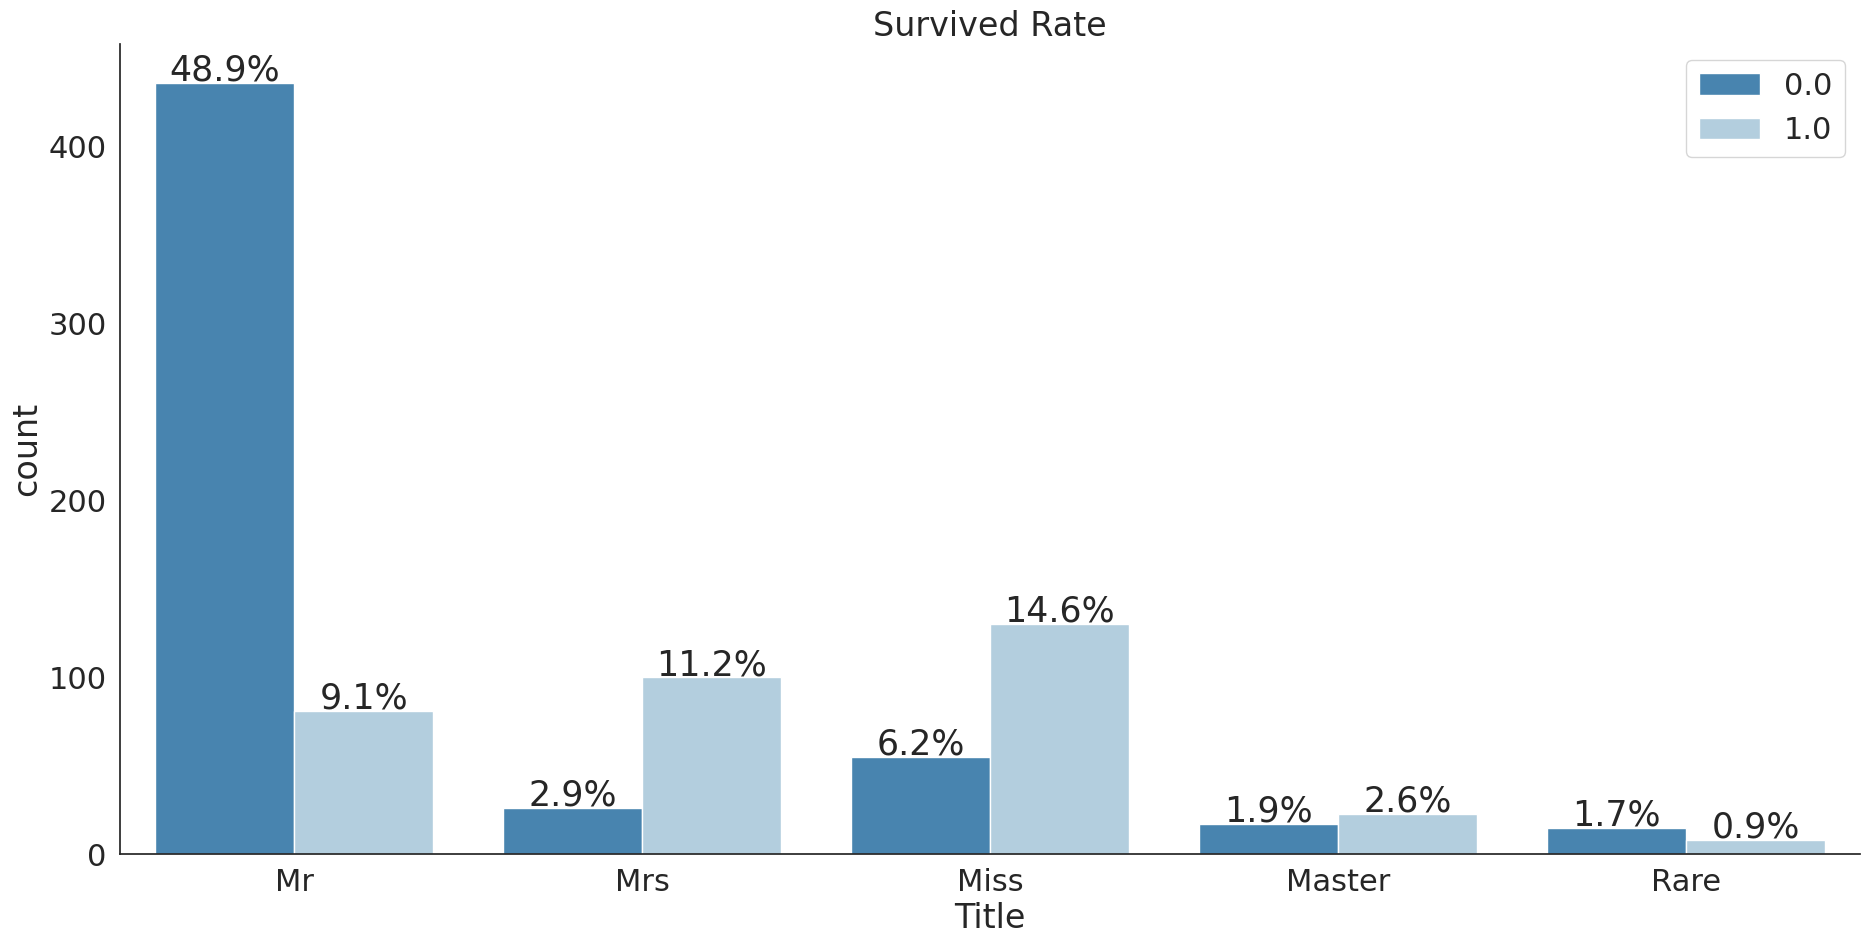

In [30]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='Title',hue ='Survived',data=data,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=25)
sns.despine()

> Passenger with Mr title having the highest death rate during the Titanic Tragedy

In [31]:
data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Has_Cabin', 'Cabin_label', 'FamilySize',
       'IsAlone', 'Title'],
      dtype='object')

### 4.2.6 Survived Rate by Embarkation Port

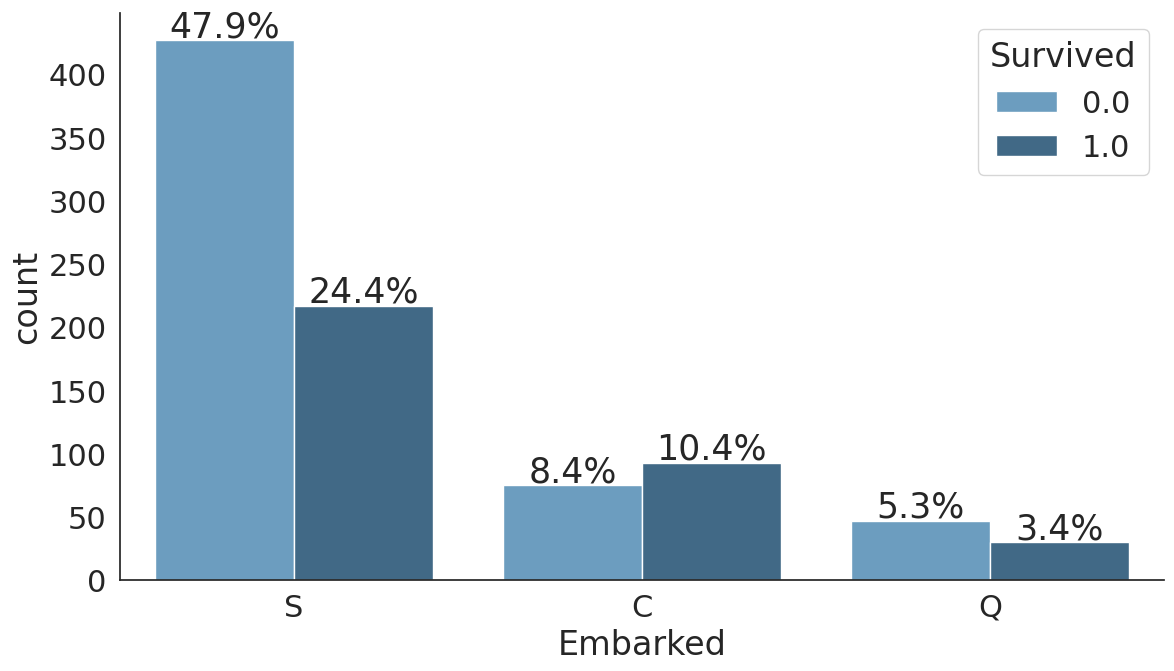

In [32]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x='Embarked',hue = 'Survived',data=data,palette="Blues_d")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total_cnt * 100:2.1f}%', ha = 'center', size = 25)
sns.despine()

- many passenger embarked from Southampton died
- passenger embarked from Cherbourg having higher survived rate

### 4.2.7 Survived Rate by Age

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


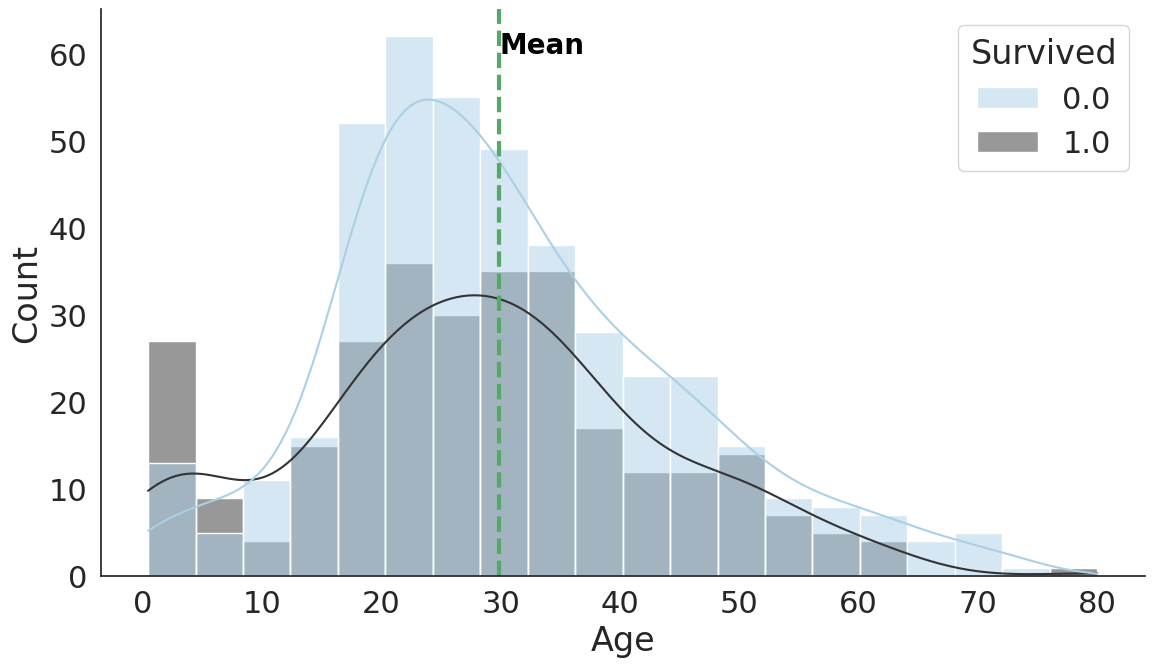

In [33]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.histplot(x="Age", hue="Survived", data=data,palette = 'Blues_d',kde=True)
plt.axvline(x=data['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(data['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [34]:
mean = data['Age'].mean()
std = data['Age'].std()
skew = data['Age'].skew()
print('Age : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age : mean: 29.8811, std: 14.4135, skew: 0.4077


### KNN Age Missing value Handling

in this case, I use KNN to impute the missing value.

>The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than n_neighbors and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during transform.

Ref: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)

In [35]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
data[['Age_knn']] = imputer.fit_transform(data[['Age']])

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

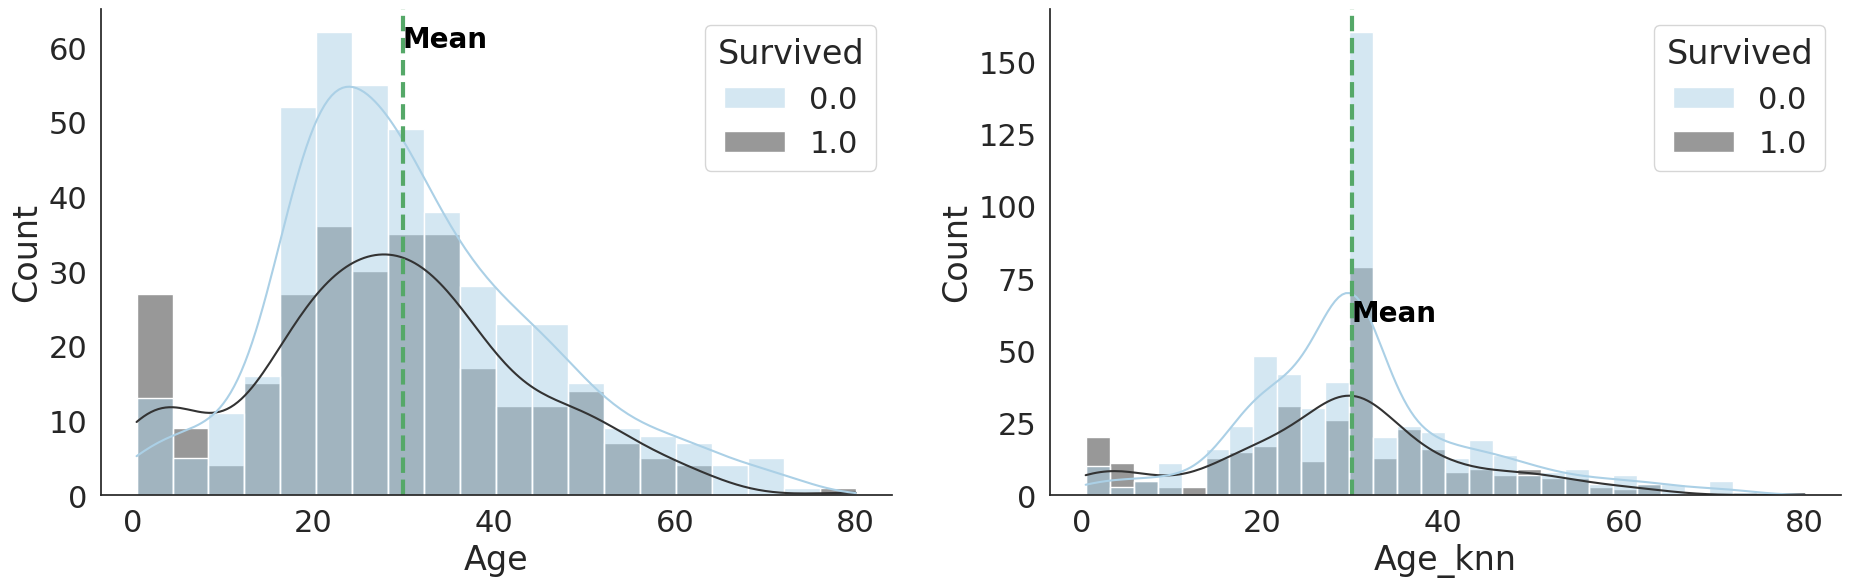

In [36]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=data,palette = 'Blues_d',kde=True)
plt.axvline(x=data['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(data['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="Age_knn", hue="Survived", data=data,palette = 'Blues_d',kde=True)
plt.axvline(x=data['Age_knn'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(data['Age_knn'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [37]:
mean = data['Age'].mean()
std = data['Age'].std()
skew = data['Age'].skew()
print('Age : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age : mean: 29.8811, std: 14.4135, skew: 0.4077


In [38]:
mean = data['Age_knn'].mean()
std = data['Age_knn'].std()
skew = data['Age_knn'].skew()
print('Age_knn : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age_knn : mean: 29.8811, std: 12.8832, skew: 0.4559


## 4.3 redefine the data after previous derivations

In [39]:
data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Has_Cabin', 'Cabin_label', 'FamilySize',
       'IsAlone', 'Title', 'Age_knn'],
      dtype='object')

In [40]:
columns_to_remove = ['Name', 'Age', 'SibSp', 'Parch','Ticket','Cabin','Has_Cabin','FamilySize']
data_used = data.drop(columns=columns_to_remove)
data_used.head()

,Survived,Pclass,Sex,Fare,Embarked,Cabin_label,IsAlone,Title,Age_knn
0,0.0,3,male,7.250,S,N,0,Mr,22.0
1,1.0,1,female,71.283,C,C,0,Mrs,38.0
2,1.0,3,female,7.925,S,N,1,Miss,26.0
3,1.0,1,female,53.100,S,C,0,Mrs,35.0
4,0.0,3,male,8.050,S,N,1,Mr,35.0


In [41]:
data_used.shape

(1309, 9)

In [42]:
#define numerical and categorical features
column_numerical = ['Age_knn','Fare']
column_categorical = list(data_used.columns)
column_categorical.remove('Age_knn')
column_categorical.remove('Fare')
column_categorical.remove('Survived')
data_type_general = dict()

for col in data_used.columns:
  if col in column_numerical:
    data_type_general[col] = 'numerical'
  else:
    data_type_general[col] = 'categorical'

tmp = pd.Series(data_type_general)
data_type_general = pd.DataFrame(tmp).T.rename({0:'general data types'})
data_type_general

,Survived,Pclass,Sex,Fare,Embarked,Cabin_label,IsAlone,Title,Age_knn
general data types,categorical,categorical,categorical,numerical,categorical,categorical,categorical,categorical,numerical


# 5. Data Pre-processing

## 5.1 Train/Test Split

In [43]:
tr_idx = data_used['Survived'].notnull()
data_y = data_used[tr_idx]['Survived']
data_X= data_used[tr_idx].drop('Survived',axis=1)
# X_test_df = data[~tr_idx].drop('Survived',axis=1) # ini untuk di akhir nanti

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3,
                                                    random_state=1, stratify=data_y)

In [44]:
print('X shape\t\t:', data_X.shape)
print('y shape\t\t:', data_y.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape\t:', X_test.shape)
print('y_test shape\t:', y_test.shape)

X shape		: (891, 8)
y shape		: (891,)

X_train shape	: (623, 8)
y_train shape	: (623,)

X_test shape	: (268, 8)
y_test shape	: (268,)


## 5.2 Label Encoding

In [45]:
#label encoding 
le = LabelEncoder()

le.fit(y_train)

y_train_encode = le.transform(y_train)
y_test_encode = le.transform(y_test)

In [46]:
le.classes_

array([0., 1.])

In [47]:
print(y_train[:5].values)
print(y_train_encode[:5])

[1. 0. 0. 0. 1.]
[1 0 0 0 1]


In [48]:
column_categorical

['Pclass', 'Sex', 'Embarked', 'Cabin_label', 'IsAlone', 'Title']

## 5.3 One-Hot Encoding

In [49]:
ohe = OneHotEncoder(sparse_output=False,drop='if_binary')

ohe.fit(X_train[column_categorical])

X_train_ohe = ohe.transform(X_train[column_categorical])
X_test_ohe = ohe.transform(X_test[column_categorical])

In [50]:
X_train_ohe

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

## 5.4 Encoded Data

In [51]:
column_ohe = ohe.get_feature_names_out()
column_ohe

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_nan', 'Cabin_label_A',
       'Cabin_label_B', 'Cabin_label_C', 'Cabin_label_D', 'Cabin_label_E',
       'Cabin_label_F', 'Cabin_label_G', 'Cabin_label_N', 'Cabin_label_T',
       'IsAlone_1', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rare'], dtype=object)

In [52]:
#overview train data
X_train.head()

,Pclass,Sex,Fare,Embarked,Cabin_label,IsAlone,Title,Age_knn
472,2,female,27.750,S,N,0,Mrs,33.0
597,3,male,0.000,S,N,1,Mr,49.0
843,3,male,6.438,C,N,1,Mr,34.5
112,3,male,8.050,S,N,1,Mr,22.0
869,3,male,11.133,S,N,0,Master,4.0


In [53]:
# create dataframe from one-hot encoded features
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=column_ohe, index=X_train.index)

# combine the numerical and encoded features
X_train_encode = pd.concat([X_train.drop(columns=column_categorical), X_train_ohe_df], axis=1)
X_train_encode.head()

,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_F,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
472,27.750,33.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
597,0.000,49.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
843,6.438,34.5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
112,8.050,22.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
869,11.133,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [54]:
#overview test data
X_test.head()

,Pclass,Sex,Fare,Embarked,Cabin_label,IsAlone,Title,Age_knn
433,3,male,7.125,S,N,1,Mr,17.0
221,2,male,13.000,S,N,1,Mr,27.0
217,2,male,27.000,S,N,0,Mr,42.0
376,3,female,7.250,S,N,1,Miss,22.0
447,1,male,26.550,S,N,1,Mr,34.0


In [55]:
# create dataframe from one-hot encoded features
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=column_ohe, index=X_test.index)

# combine the numerical and encoded features
X_test_encode = pd.concat([X_test.drop(columns=column_categorical), X_test_ohe_df], axis=1)
X_test_encode.head()

,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_F,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
433,7.125,17.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
221,13.000,27.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
217,27.000,42.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
376,7.250,22.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
447,26.550,34.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [56]:
#combine
# combine the X-train and X-test
data_encode = pd.concat([X_train_encode, X_test_encode], axis=0)

# combine with the y-train
data_encode = data_encode.join(pd.Series(y_train_encode, name='Survived', index=X_train_encode.index), lsuffix='_1', rsuffix='_2')

# combine with the y-test
data_encode = data_encode.join(pd.Series(y_test_encode, name='Survived', index=X_test_encode.index), lsuffix='_1', rsuffix='_2')

# merging the y-train and y-test column
data_encode['Survived_1'].fillna(data_encode['Survived_2'], inplace=True)
data_encode.drop(columns='Survived_2', inplace=True)
data_encode.rename(columns={'Survived_1':'Survived'}, inplace=True)

data_encode.head()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Survived
472,27.750,33.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
597,0.000,49.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
843,6.438,34.5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
112,8.050,22.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
869,11.133,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 5.5 Feature Scaling

In [57]:
#scaling
#for numerical data
X_train_scale = X_train_encode.copy()
X_test_scale = X_test_encode.copy()

for i in column_numerical:
  scaler = MinMaxScaler() #between 0 and 1
  scaler.fit(X_train_scale[[i]])

  X_train_scale[[i]] = scaler.transform(X_train_scale[[i]])
  X_test_scale[[i]] = scaler.transform(X_test_scale[[i]])

In [58]:
# combine the X-train and X-test
data_scale = pd.concat([X_train_scale, X_test_scale], axis=0)

# combine with the y-train
data_scale = data_scale.join(pd.Series(y_train_encode, name='Survived', index=X_train_scale.index), lsuffix='_1', rsuffix='_2')

# combine with the y-test
data_scale = data_scale.join(pd.Series(y_test_encode, name='Survived', index=X_test_scale.index), lsuffix='_1', rsuffix='_2')

# merging the y-train and y-test column
data_scale['Survived_1'].fillna(data_scale['Survived_2'], inplace=True)
data_scale.drop(columns='Survived_2', inplace=True)
data_scale.rename(columns={'Survived_1':'Survived'}, inplace=True)

data_scale.head()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Survived
472,0.054,0.443,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
597,0.000,0.660,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
843,0.013,0.463,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
112,0.016,0.293,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
869,0.022,0.049,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [59]:
data_scale_train = pd.concat([X_train_scale, pd.Series(y_train_encode, name='Survived', index=X_train_scale.index)], axis=1)
data_scale_train.head()

,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Survived
472,0.054,0.443,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
597,0.000,0.660,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
843,0.013,0.463,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
112,0.016,0.293,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
869,0.022,0.049,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


# 6. Model Development

## 6.1 Helper Function

In [60]:
def get_score(y_pred_list, y_test, average=None, plot=True, axis=0, cmap='Blues'):
  model_name = []
  accuracy = []
  precision = []
  recall = []
  f1 = []
  roc_auc = []

  for name, y_pred in y_pred_list.items():
    model_name.append(name)
    if average != None:
      accuracy.append(accuracy_score(y_test, y_pred))
      precision.append(precision_score(y_test, y_pred, average=average))
      recall.append(recall_score(y_test, y_pred, average=average))
      f1.append(f1_score(y_test, y_pred, average=average))
      roc_auc.append(roc_auc_score(y_test, y_pred, average=average))

      score_list = {
        'model':model_name,
        'accuracy':accuracy,
        f'{average}_avg_precision':precision,
        f'{average}_avg_recall':recall,
        f'{average}_avg_f1_score':f1,
        'roc_auc':roc_auc
      }
    else:
      accuracy.append(accuracy_score(y_test, y_pred))
      precision.append(precision_score(y_test, y_pred))
      recall.append(recall_score(y_test, y_pred))
      f1.append(f1_score(y_test, y_pred))
      roc_auc.append(roc_auc_score(y_test, y_pred))

      score_list = {
        'model':model_name,
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'roc_auc':roc_auc
      }

  score_df = pd.DataFrame(score_list).set_index('model')

  if plot:
    display(score_df.style.background_gradient(axis=axis, cmap=cmap))

  return score_df

In [61]:
def fbeta_score(accuracy, recall, beta=1):
  fbeta_score = (1 + beta**2) * (accuracy*recall)/(beta*accuracy+recall)
  
  return fbeta_score

## 6.2 Default Parameter

In [62]:
model_list = {
    'Logistic Regression':LogisticRegression(max_iter=1000, random_state=1),
    'Ridge Classifier':RidgeClassifier(random_state=1),
    'KNN':KNeighborsClassifier(),
    'SVC':SVC(random_state=1),
    'Neural Network':MLPClassifier(max_iter=1000, random_state=1),
    'Decision Tree':DecisionTreeClassifier(random_state=1),
    'Random Forest':RandomForestClassifier(random_state=1),
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}

X_train_model = X_train_scale.copy() 
y_train_model = y_train_encode.copy() 

X_test_model = X_test_scale.copy()
y_test_model = y_test_encode.copy()

In [63]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Logistic Regression,0.824627,0.819788,0.804678,0.810572,0.804678
Ridge Classifier,0.817164,0.810284,0.798617,0.803363,0.798617
KNN,0.791045,0.784257,0.766461,0.772771,0.766461
SVC,0.820896,0.828813,0.788879,0.800335,0.788879
Neural Network,0.809701,0.811762,0.779788,0.789513,0.779788
Decision Tree,0.768657,0.755902,0.751927,0.753720,0.751927
Random Forest,0.817164,0.811512,0.796793,0.802511,0.796793
Gradient Boosting Classifier,0.824627,0.821286,0.802854,0.809725,0.802854
AdaBoost Classifier,0.791045,0.783076,0.768285,0.773799,0.768285


LightGBM generates the best result, apparently. let's focus on boosting methods

In [64]:
model_list = {
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}

In [65]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_smote = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.824627,0.821286,0.802854,0.809725,0.802854
AdaBoost Classifier,0.791045,0.783076,0.768285,0.773799,0.768285
CatBoost Classifier,0.820896,0.817902,0.797999,0.805233,0.797999
Hist Gradient Boosting,0.828358,0.823226,0.809532,0.815006,0.809532
XGBoost,0.787313,0.777513,0.767079,0.771259,0.767079
LightGBM,0.832090,0.826669,0.814387,0.819415,0.814387


## 6.3 Feature Selection

### 6.3.1 Anova Feature Selection

In [66]:
threshold = 13 #check treshold

filter = SelectKBest(score_func=f_classif, k=threshold) #anova based f-value between features
filter.fit(X_train_model, y_train_model)

X_train_filter = filter.transform(X_train_model)
X_test_filter = filter.transform(X_test_model)

print('before filter\t:', X_train_model.shape)
print('after filter\t:', X_train_filter.shape)

before filter	: (623, 25)
after filter	: (623, 13)


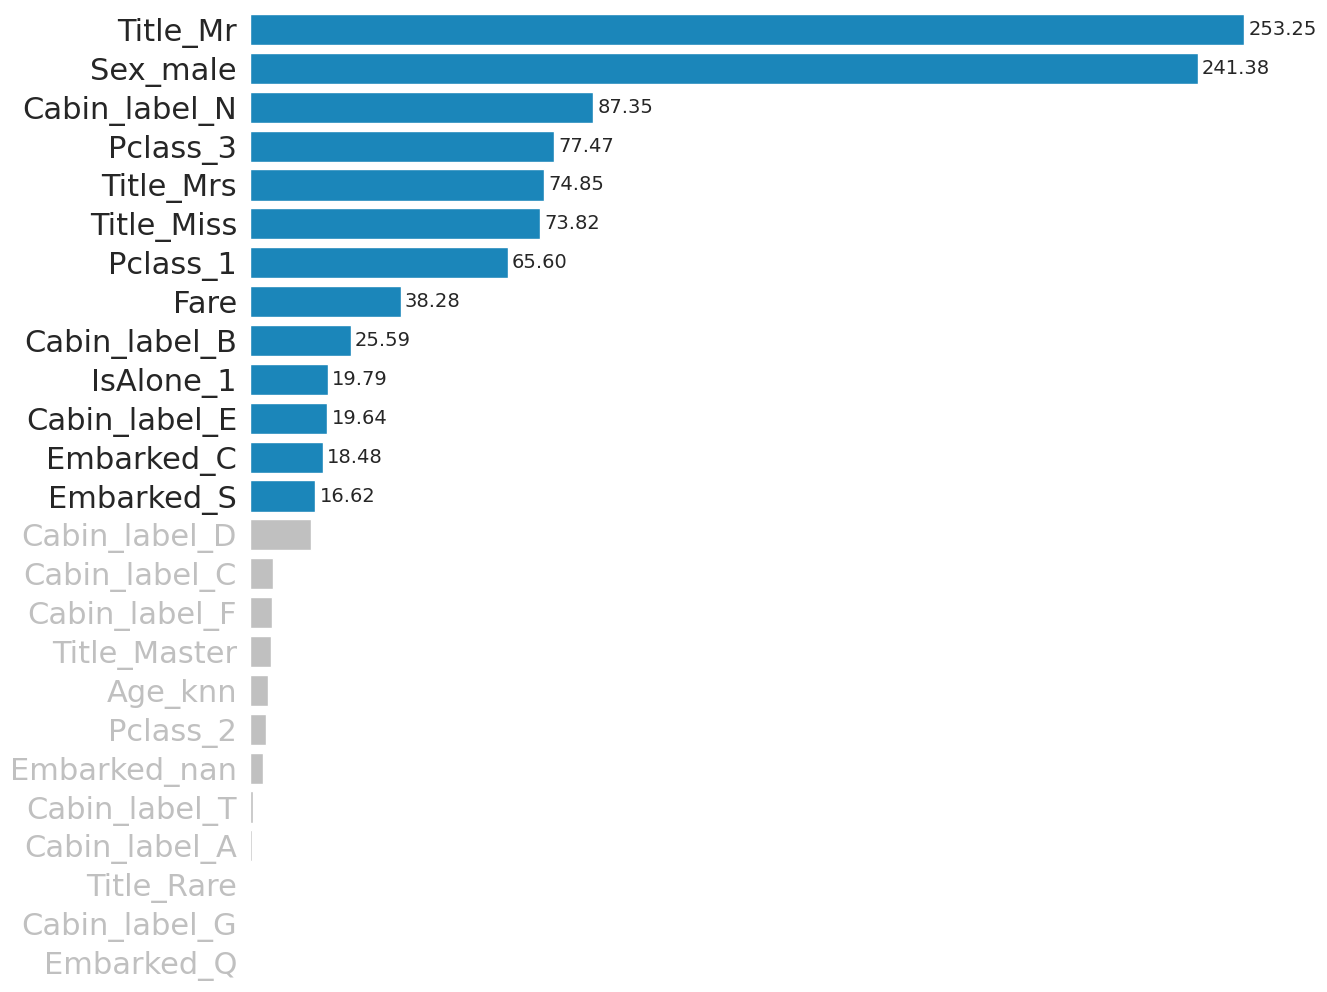

In [67]:
# viz
selected_feature = filter.get_feature_names_out()
feature_name = filter.feature_names_in_
feature_score = filter.scores_

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_score':feature_score}).sort_values('feature_score', ascending=False)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
selected = list()
for i in range(0, X_train_model.shape[1]):
  if i < threshold:
    selected.append(True)
  else:
    selected.append(False)

selected_s = pd.Series(selected, name='selected')
feature_selection = pd.concat([feature_selection, selected_s], axis=1)

# highlight the top features
palette = []
for i in range(0, len(feature_selection)):
  if i < threshold:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(data=feature_selection, x='feature_score', y='feature_name', ax=ax, palette=palette)
# ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

# custom bar label visibility
for con in ax.containers:
  # labels = [val for val in con.datavalues]
  labels = con.datavalues
  labels_len = len(labels)

  # masking the top features
  np.put(labels, np.arange(threshold,labels_len), [-1])

  # hide the labels for non-top features
  labels = [f'{val:.2f}' if val != -1 else '' for val in labels]

  ax.bar_label(con, labels=labels, padding=3, fontsize=14, fontweight='medium')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [68]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_filter = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.813433,0.803957,0.799235,0.801387,0.799235
AdaBoost Classifier,0.776119,0.763911,0.759812,0.761665,0.759812
CatBoost Classifier,0.824627,0.821286,0.802854,0.809725,0.802854
Hist Gradient Boosting,0.802239,0.790764,0.793792,0.792166,0.793792
XGBoost,0.824627,0.817345,0.808326,0.812177,0.808326
LightGBM,0.813433,0.803344,0.801059,0.802150,0.801059


### 6.3.2 RFE - Wrapper Method

In [69]:
# estimator parameter:
# A supervised learning estimator with a fit method
# that provides information about feature importance
# (e.g. coef_, feature_importances_) -> DecisionTree uses feature importance

threshold = 13
estimator = LogisticRegression(random_state=1)

wrapper = RFE(estimator=estimator, n_features_to_select=threshold)
wrapper.fit(X_train_model, y_train_model)

X_train_wrap = wrapper.transform(X_train_model)
X_test_wrap = wrapper.transform(X_test_scale)

print('before wrapper\t:', X_train_model.shape)
print('after wrapper\t:', X_train_wrap.shape)

before wrapper	: (623, 25)
after wrapper	: (623, 13)


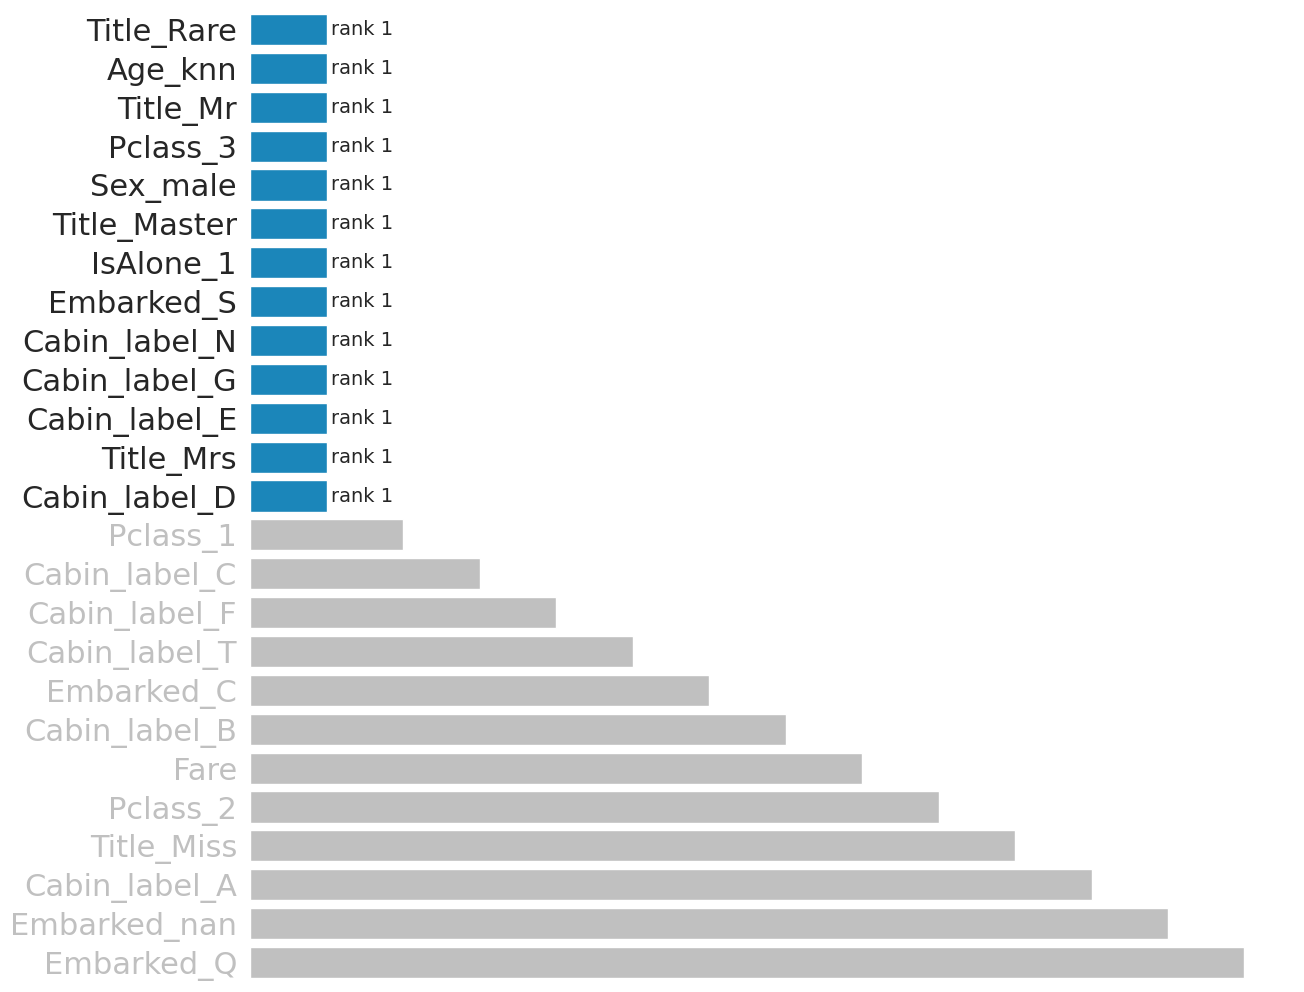

In [70]:
# viz
selected_feature = wrapper.get_feature_names_out()
feature_name = wrapper.feature_names_in_
feature_ranking = wrapper.ranking_

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_ranking':feature_ranking}).sort_values('feature_ranking', ascending=True)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
feature_selection['selected'] = feature_selection['feature_ranking'].apply(lambda x: True if x == 1 else False)

# highlight the top features
palette = []
for i in range(0, len(feature_selection)):
  if i < threshold:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(data=feature_selection, x='feature_ranking', y='feature_name', ax=ax, palette=palette)
# ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

# custom bar label visibility
for con in ax.containers:
  # labels = [val for val in con.datavalues]
  labels = con.datavalues
  labels_len = len(labels)

  # masking the top features
  np.put(labels, np.arange(threshold,labels_len), [-1])

  # hide the labels for non-top features
  labels = [f'rank {val:.0f}' if val != -1 else '' for val in labels]

  ax.bar_label(con, labels=labels, padding=3, fontsize=14, fontweight='medium')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [71]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_wrap, y_train_model)
  y_pred_list[name] = model.predict(X_test_wrap)

score_wrap = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.794776,0.790634,0.767667,0.775247,0.767667
AdaBoost Classifier,0.794776,0.784884,0.776787,0.780207,0.776787
CatBoost Classifier,0.805970,0.804372,0.778582,0.786989,0.778582
Hist Gradient Boosting,0.802239,0.799195,0.775552,0.783419,0.775552
XGBoost,0.809701,0.804557,0.787084,0.793532,0.787084
LightGBM,0.817164,0.809230,0.800441,0.804184,0.800441


### 6.3.3 Embedded Method

In [72]:
    # estimator parameter:
    # A supervised learning estimator with a fit method
    # that provides information about feature importance
    # (e.g. coef_, feature_importances_) -> DecisionTree uses feature importance

    estimator = LogisticRegression(random_state=1)

    embedded = SelectFromModel(estimator=estimator, threshold='median') #treshold mau diambil dari apa
    embedded.fit(X_train_model, y_train_model)

    X_train_embed = embedded.transform(X_train_model)
    X_test_embed = embedded.transform(X_test_scale)

    print('before embedded\t:', X_train_model.shape)
    print('after embedded\t:', X_train_embed.shape)

before embedded	: (623, 25)
after embedded	: (623, 13)


threshold: 0.599


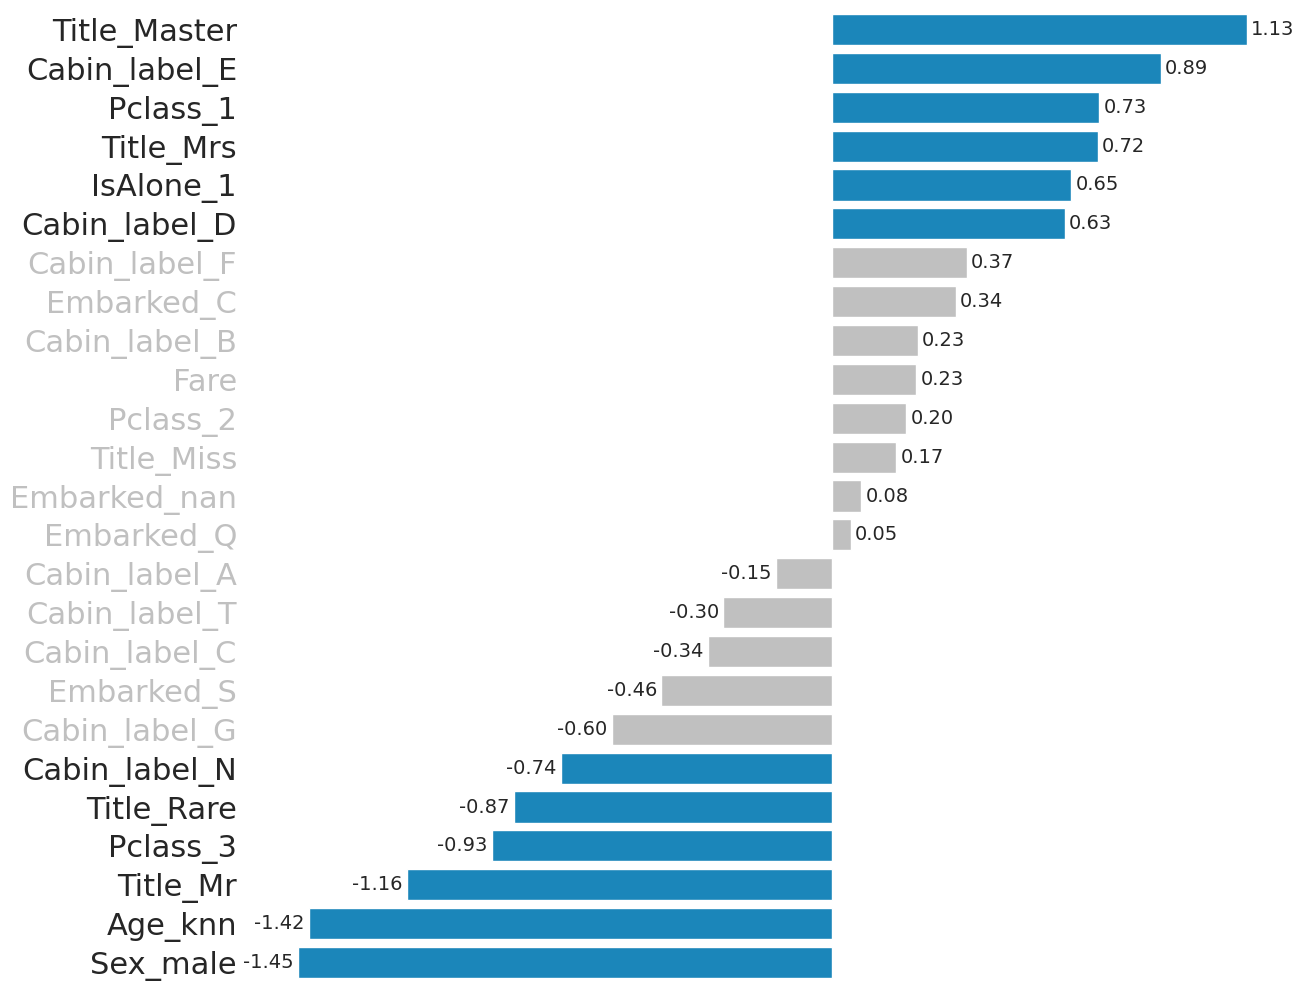

In [73]:
# viz
# selected_feature = embedded.get_feature_names_out()
feature_name = embedded.feature_names_in_
feature_importance = embedded.estimator_.coef_[0]

# add to dataframe
feature_selection = pd.DataFrame({'feature_name':feature_name, 'feature_importance':feature_importance}).sort_values('feature_importance', ascending=False)
feature_selection.reset_index(drop=True, inplace=True)

# create flag
threshold = embedded.threshold_
print(f'threshold: {threshold:.3f}')
feature_selection['selected'] = feature_selection['feature_importance'].apply(lambda x: True if (abs(x) > threshold) else False)

# highlight the top features
palette = []
for flag in feature_selection['selected']:
  if flag:
    palette.append('#008FD5')
  else:
    palette.append('silver')

fig, ax = plt.subplots(figsize=(12,12))

# sns.barplot(x=corr_target.values, y=corr_target.index, ax=ax, palette=palette)
sns.barplot(data=feature_selection, x='feature_importance', y='feature_name', ax=ax, palette=palette)
ax.bar_label(ax.containers[0], padding=3, fmt='%.2f', fontsize=14, fontweight='medium')

# custom y label color
for i, label in enumerate(ax.yaxis.get_ticklabels()):
  if feature_selection.loc[i, 'selected'] == False:
    label.set_color('silver')

ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True)
plt.show()

In [74]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_embed, y_train_model)
  y_pred_list[name] = model.predict(X_test_embed)

score_embed = get_score(y_pred_list, y_test_model, average='macro')

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.802239,0.800983,0.773728,0.782358,0.773728
AdaBoost Classifier,0.802239,0.792257,0.786496,0.789055,0.786496
CatBoost Classifier,0.817164,0.818323,0.789497,0.798783,0.789497
Hist Gradient Boosting,0.791045,0.784257,0.766461,0.772771,0.766461
XGBoost,0.817164,0.814520,0.793145,0.800713,0.793145
LightGBM,0.805970,0.802629,0.780406,0.788013,0.780406


### 6.3.4 Feature Selection Results Comparison

In [75]:
#feature selection comparison
score_smote_mean = pd.DataFrame(score_smote.mean(), columns=['original']).T #this is actually no smote, just old naming stuff
score_filter_mean = pd.DataFrame(score_filter.mean(), columns=['filter method']).T
score_wrap_mean = pd.DataFrame(score_wrap.mean(), columns=['wrapper method']).T
score_embed_mean = pd.DataFrame(score_embed.mean(), columns=['embedded method']).T

score_compare = pd.concat([score_smote_mean,
                           score_filter_mean,
                           score_wrap_mean,
                           score_embed_mean], axis=0)

score_compare.style.background_gradient(axis=0)

,accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,roc_auc
original,0.814055,0.808279,0.793356,0.799073,0.793356
filter method,0.809080,0.800101,0.794180,0.796545,0.794180
wrapper method,0.804104,0.798812,0.781019,0.787263,0.781019
embedded method,0.805970,0.802162,0.781622,0.788616,0.781622


## 6.4 Hyperparameter Tuning

In [76]:
model_list = {
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1),
    'AdaBoost Classifier':AdaBoostClassifier(random_state=1),
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False),
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1),
    'XGBoost':XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM':LGBMClassifier(random_state=1),
}

In [77]:
#need to re-tuning
    #since it's a different case 
model_list_tuned = {
    'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1,
                                                              max_depth=2,
                                                              n_estimators=500,
                                                              learning_rate=0.02),
              
    'AdaBoost Classifier':AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1, max_depth=2),
                                             random_state=1,
                                             n_estimators=80,
                                             learning_rate=0.04),
              
    'CatBoost Classifier':CatBoostClassifier(random_state=1, verbose=False,
                                             n_estimators=1000,
                                             learning_rate=0.004,
                                             scale_pos_weight=1.1),
              
    'Hist Gradient Boosting':HistGradientBoostingClassifier(random_state=1,
                                                            max_iter=200, 
                                                            learning_rate=0.01,
                                                            max_depth=5),
    'XGBoost':XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss',
                            colsample_bytree=0.1,
                            learning_rate=0.005),
              
    'LightGBM':LGBMClassifier(random_state=1,
                              num_leaves=10,
                              n_estimators=175,
                              learning_rate=0.01)
}

### 6.4.1 Without Feature Selection result

before tuning

In [78]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_no_fs_not_tuned = get_score(y_pred_list, y_test_model)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.824627,0.811111,0.708738,0.756477,0.802854
AdaBoost Classifier,0.791045,0.758242,0.669903,0.711340,0.768285
CatBoost Classifier,0.820896,0.808989,0.699029,0.750000,0.797999
Hist Gradient Boosting,0.828358,0.806452,0.728155,0.765306,0.809532
XGBoost,0.787313,0.744681,0.679612,0.710660,0.767079
LightGBM,0.832090,0.808511,0.737864,0.771574,0.814387


after tuning

In [79]:
y_pred_list = dict()

for name, model in model_list_tuned.items():
  model.fit(X_train_model, y_train_model)
  y_pred_list[name] = model.predict(X_test_model)

score_no_fs_tuned = get_score(y_pred_list, y_test_model)

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.820896,0.839506,0.660194,0.739130,0.790703
AdaBoost Classifier,0.832090,0.871795,0.660194,0.751381,0.799794
CatBoost Classifier,0.828358,0.813187,0.718447,0.762887,0.807708
Hist Gradient Boosting,0.817164,0.813953,0.679612,0.740741,0.791321
XGBoost,0.615672,0.000000,0.000000,0.000000,0.500000
LightGBM,0.824627,0.825581,0.689320,0.751323,0.799206


In [80]:
score_compare_accuracy = score_no_fs_not_tuned.loc[:, ['accuracy']]

score_compare_accuracy = score_compare_accuracy.join(score_no_fs_tuned.loc[:, ['accuracy']],
                                   lsuffix='_not_tuned', rsuffix='_tuned')

score_compare_accuracy.style.background_gradient(axis=1)

,accuracy_not_tuned,accuracy_tuned
model,,
Gradient Boosting Classifier,0.824627,0.820896
AdaBoost Classifier,0.791045,0.832090
CatBoost Classifier,0.820896,0.828358
Hist Gradient Boosting,0.828358,0.817164
XGBoost,0.787313,0.615672
LightGBM,0.832090,0.824627


> LightGBM before tuning still having the best metric results

### 6.4.2 with Feature Selection

before tuning

In [81]:
y_pred_list = dict()

for name, model in model_list.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_fs_not_tuned = get_score(y_pred_list, y_test_model)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.813433,0.767677,0.737864,0.752475,0.799235
AdaBoost Classifier,0.776119,0.717172,0.689320,0.702970,0.759812
CatBoost Classifier,0.824627,0.811111,0.708738,0.756477,0.802854
Hist Gradient Boosting,0.802239,0.735849,0.757282,0.746411,0.793792
XGBoost,0.824627,0.791667,0.737864,0.763819,0.808326
LightGBM,0.813433,0.762376,0.747573,0.754902,0.801059


after tuning

In [82]:
y_pred_list = dict()

for name, model in model_list_tuned.items():
  model.fit(X_train_filter, y_train_model)
  y_pred_list[name] = model.predict(X_test_filter)

score_fs_tuned = get_score(y_pred_list, y_test_model)

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
Gradient Boosting Classifier,0.798507,0.763441,0.689320,0.724490,0.777994
AdaBoost Classifier,0.805970,0.800000,0.660194,0.723404,0.778582
CatBoost Classifier,0.824627,0.804348,0.718447,0.758974,0.804678
Hist Gradient Boosting,0.817164,0.770000,0.747573,0.758621,0.804089
XGBoost,0.615672,0.000000,0.000000,0.000000,0.500000
LightGBM,0.817164,0.793478,0.708738,0.748718,0.796793


comparison

In [83]:
score_compare_accuracy = score_fs_not_tuned.loc[:, ['accuracy']]

score_compare_accuracy = score_compare_accuracy.join(score_fs_tuned.loc[:, ['accuracy']],
                                   lsuffix='_not_tuned', rsuffix='_tuned')

score_compare_accuracy.style.background_gradient(axis=1)

,accuracy_not_tuned,accuracy_tuned
model,,
Gradient Boosting Classifier,0.813433,0.798507
AdaBoost Classifier,0.776119,0.805970
CatBoost Classifier,0.824627,0.824627
Hist Gradient Boosting,0.802239,0.817164
XGBoost,0.824627,0.615672
LightGBM,0.813433,0.817164


In [84]:
accuracy = score_no_fs_tuned['accuracy']
recall = score_no_fs_tuned['recall']

score_no_fs_tuned['fbeta'] = fbeta_score(accuracy, recall, beta=1)

score_no_fs_tuned.loc[:, ['accuracy', 'recall', 'fbeta']].style.background_gradient(axis=0)

,accuracy,recall,fbeta
model,,,
Gradient Boosting Classifier,0.820896,0.660194,0.731827
AdaBoost Classifier,0.832090,0.660194,0.736242
CatBoost Classifier,0.828358,0.718447,0.769497
Hist Gradient Boosting,0.817164,0.679612,0.742067
XGBoost,0.615672,0.000000,0.000000
LightGBM,0.824627,0.689320,0.750927


In [85]:
accuracy = score_fs_tuned['accuracy']
recall = score_fs_tuned['recall']

score_fs_tuned['fbeta'] = fbeta_score(accuracy, recall, beta=1)

score_fs_tuned.loc[:, ['accuracy', 'recall', 'fbeta']].style.background_gradient(axis=0)

,accuracy,recall,fbeta
model,,,
Gradient Boosting Classifier,0.798507,0.689320,0.739907
AdaBoost Classifier,0.805970,0.660194,0.725835
CatBoost Classifier,0.824627,0.718447,0.767884
Hist Gradient Boosting,0.817164,0.747573,0.780821
XGBoost,0.615672,0.000000,0.000000
LightGBM,0.817164,0.708738,0.759099


# 7. Final Model

After some modelling processes, there is no model could perform better than **LightGBM method - without feature selection**

In [86]:
model = LGBMClassifier(random_state=1)
model.fit(X_train_model, y_train_model)

y_pred = model.predict(X_test_model)

print(classification_report(y_test_model, y_pred, digits=3))

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

It generates **accuracy of 83.2%** and **precision of 82.7%**.

# 8. Model Explainer

In [87]:
shap.initjs()

In [88]:
input_test = pd.DataFrame(X_test_model, columns =list(X_train_model.columns))
input_test = pd.DataFrame(input_test.iloc[1]).T
input_test

,Fare,Age_knn,Pclass_1,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,...,Cabin_label_F,Cabin_label_G,Cabin_label_N,Cabin_label_T,IsAlone_1,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
221,0.025,0.361,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [89]:
explainer = shap.Explainer(model, X_train_model, feature_names=list(X_train_model.columns)) #build explainer
shap_values = explainer.shap_values(X_test_model, check_additivity=False) #shap for test data
shap_values_single = explainer(input_test, check_additivity=False) #clear, unused single input
shap_values_multiple = explainer(X_test_model, check_additivity=False) #clear, used test filter
expected_value = explainer.expected_value
print(f'Baseline Prediction: {expected_value}')

Baseline Prediction: -0.8552193029651665


> SHAP baseline prediction score of -0.8552 indicates that the model's initial prediction leans heavily towards predicting that passengers did not survive the sinking. This aligns with the tragic reality of the Titanic disaster, where a significant portion of the passengers and crew perished due to the lack of lifeboats and the severity of the collision with the iceberg. About 70% of passenger crew is died at the tragedy.

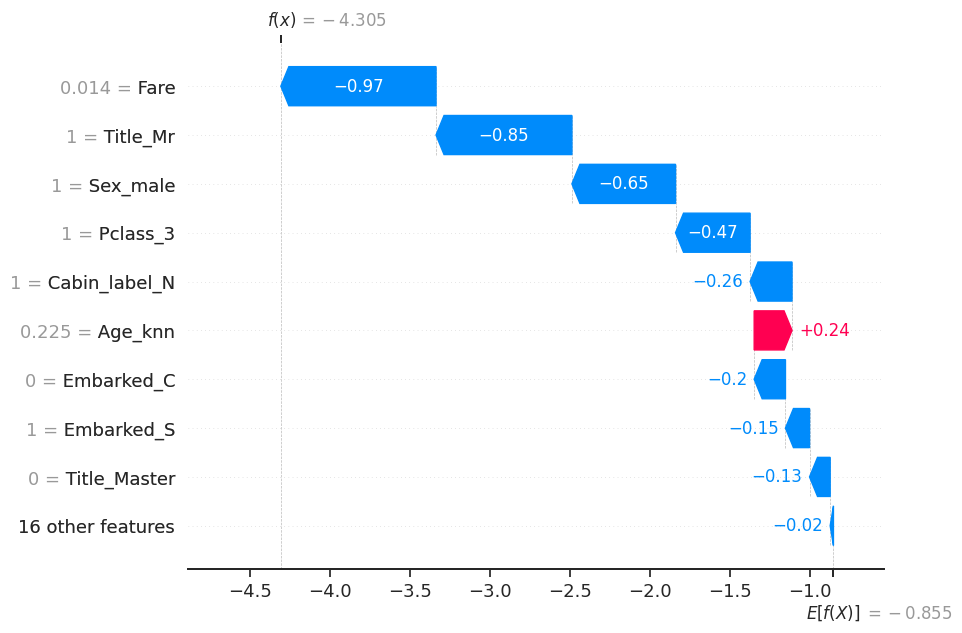

In [90]:
shap.plots.waterfall(shap_values_multiple[0])

# 9. Conclusion

Based on the SHAP waterfall plot and the provided feature contributions, here's an interpretation of the model's prediction:

1. Fare (-0.49): The negative contribution of Fare suggests that lower ticket prices are associated with a decreased likelihood of survival. This aligns with the historical knowledge that passengers with cheaper tickets, typically those in third class, were less likely to survive due to their accommodation in the lower decks, farther from the lifeboats.

2. Title_Mr (-0.85): The negative contribution of Title_Mr indicates that being identified as "Mr" rather than another title (e.g., "Mrs", "Miss") is associated with a decreased chance of survival. This is consistent with the societal norms of the time, where women and children were prioritized for lifeboats over men.

3. Sex_Male (-0.65): The negative contribution of Sex_Male implies that being male is associated with a reduced likelihood of survival. This aligns with the "women and children first" protocol followed during the Titanic tragedy, where women and children were given priority in boarding lifeboats.

4. Third Ticket Class (-0.47): The negative contribution of the third ticket class suggests that passengers traveling in the third class (lower socioeconomic status) are less likely to survive compared to those in higher classes. This is consistent with historical records indicating that passengers in higher classes had better access to lifeboats and were more likely to survive.